In [1]:
__doc__ = """
============================================
perturbation_rank - perturb.py
============================================
Perturbation Ranking 

The input perturbation algorithm, works by evaluating a trained model’s accuracy with each of the inputs individually shuffled from a data set.

Shuffling an input causes it to become useless—effectively removing it from the model. More important inputs will produce a less accurate score when they are removed by shuffling them.

This process makes sense, because important features will contribute to the accuracy of the model.
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Evaluating Feature Importance
def perturbation_rank(model, x, y, feature_names):
    errors = []

    for i in range(x.shape[1]):
        print('perturb {}'.format(feature_names[i]))
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])


        pred = model.predict(pd.DataFrame(x, columns=feature_names))
        error = np.sqrt(metrics.mean_squared_error(y, pred))

        errors.append(error)
        x[:, i] = hold

    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'feature names':feature_names, 'importance': importance, 'error':errors}

    result = pd.DataFrame(data, columns = ['feature names', 'importance', 'error'])
    result.sort_values(by=['importance'], ascending=False,inplace=True)
    result.set_index('feature names', inplace=True)

    result['importance'].plot.barh(title='Feature Importances', figsize=(45,35), fontsize=25)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    return result

In [2]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

from sklearn.model_selection import train_test_split

from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

class dateEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Processing DateTime Data')
        print('Encoding....')
        retX = pd.DataFrame()

        for colname, col in X.iteritems():
            retX[colname+'_dayofweek'] = col.dt.dayofweek
            retX[colname+'_weekday'] = col.dt.weekday
            retX[colname+'_hour'] = col.dt.hour
            retX[colname+'_minute'] = col.dt.minute
            retX[colname+'_day'] = col.dt.day
            retX[colname+'_month'] = col.dt.month
            #retX[colname+'_year'] = col.dt.year
    
        return retX
    
def prepare_pipeline(ds):
    
    numeric_features = ds.select_dtypes(include=[np.float or np.float]).columns.tolist()
    categorical_features = ds.select_dtypes(include=['object']).columns.tolist()
    date_features = ds.select_dtypes(include=[np.datetime64]).columns.tolist()
    
    cachedir = mkdtemp()
    memory = Memory(cachedir=cachedir, verbose=1)

    date_transformer = Pipeline(memory=memory, steps=[('dateEncoder', dateEncoder()), ('imputer', SimpleImputer(strategy='median', verbose=1))])
    numeric_transformer = Pipeline(memory=memory, steps=[('imputer', SimpleImputer(strategy='median', verbose=1))])
    categorical_transformer = Pipeline(memory=memory, steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing', verbose=1)),
                                                             ('onehot', OneHotEncoder(handle_unknown='ignore'))])    

    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_transformer, categorical_features)])

    proc = Pipeline(steps=[('preprocessor', preprocessor)])
    
    return proc


class Anomaly_regressor(xgb.XGBRegressor):
    def __init__(self, nthread=-1, n_jobs=-1, max_depth=500, subsample=0.5, missing=None, colsample_bytree=0.5, 
                                    colsample_bylevel=0.5, reg_alpha=0.01, learning_rate=0.1, n_estimators=1000, random_state=123):

                                    
        super(Anomaly_regressor, self).__init__(nthread=nthread, n_jobs=n_jobs, max_depth=max_depth,missing=missing, subsample=subsample, \
                                                random_state=random_state, colsample_bytree=colsample_bytree, 
                                    colsample_bylevel=colsample_bylevel, reg_alpha=reg_alpha, learning_rate=learning_rate, n_estimators=n_estimators)
        self.preprocessor = None
        
    def fit(self, X, y):
        self.preprocessor = prepare_pipeline(X)
        print('Start Data pre-processing ...')
        self.preprocessor = self.preprocessor.fit(X)
        X = self.preprocessor.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=4891)
        super(Anomaly_regressor, self).fit(X_train, y_train, eval_set= ((X_train, y_train),(X_test, y_test)))
        return self
    
    def predict(self, X):
        return super(Anomaly_regressor, self).predict(self.preprocessor.transform(X))
         

In [3]:
identifiers = ['user_id', 'request_id', 'target_recipient_id']
date_cols = ['date_user_created', 'date_request_submitted', 'date_request_received','date_request_transferred', \
             'first_attempt_date', 'first_success_date']
categorical = ['addr_country_code', 'addr_city', 'recipient_country_code', 'flag_personal_business', 'payment_type', \
               'payment_status', 'ccy_send', 'ccy_target', 'transfer_to_self', 'sending_bank_name',  'sending_bank_country',\
               'payment_reference_classification', 'device']

In [4]:
import pickle
filename = "ds.pkl"
ds = pickle.load(open(filename, 'rb'))

In [5]:
X = ds[[c for c in ds.columns.tolist() if c not in identifiers+['anomalous_score', 'anomalous']]]
y = ds['anomalous_score'].values

In [6]:
for colname in date_cols:
    X[colname+'_dayofweek'] = X[colname].dt.dayofweek
    X[colname+'_weekday'] = X[colname].dt.weekday
    X[colname+'_hour'] = X[colname].dt.hour
    X[colname+'_minute'] = X[colname].dt.minute
    X[colname+'_day'] = X[colname].dt.day
    X[colname+'_month'] = X[colname].dt.month

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [12]:
X = X[[c for c in X.columns.tolist() if c not in date_cols]]

In [13]:
X, X_holdout, y, y_holdout = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=4891)

In [14]:
areg = Anomaly_regressor()

In [15]:
areg.fit(X, y)

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\KHALID~1\\AppData\\Local\\Temp\\tmpthj7qizd'", use "location='C:\\Users\\KHALID~1\\AppData\\Local\\Temp\\tmpthj7qizd'" instead.


Start Data pre-processing ...
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strategy='constant', verbose=1), 
      addr_country_code           addr_city recipient_country_code  \
65886               GBR               LEEDS                     PL   
50104               USA             NORFOLK                     CA   
15953               EST             TALLINN                     GB   
37082               FRA            BERGERAC                     US   
79620               NLD           EINDHOVEN                     IN   
37348               GBR              LONDON                     IN   
42537               GBR              LONDON                     ES   
60940               GBR              LONDON                     AE   
79087               GBR       FINSBURY PARK                     PT   
..., 


C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.29s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
[0]	validation_0-rmse:0.44855	validation_1-rmse:0.448564
[1]	validation_0-rmse:0.4037	validation_1-rmse:0.403714
[2]	validation_0-rmse:0.363334	validation_1-rmse:0.363348
[3]	validation_0-rmse:0.327005	validation_1-rmse:0.327019
[4]	validation_0-rmse:0.294308	validation_1-rmse:0.294322
[5]	validation_0-rmse:0.26488	validation_1-rmse:0.264894
[6]	validation_0-rmse:0.238394	validation_1-rmse:0.238408
[7]	validation_0-rmse:0.21456	validation_1-rmse:0.214574
[8]	validation_0-rmse:0.193109	validation_1-rmse:0.193123
[9]	validation_0-rmse:0.173801	validation_1-rmse:0.173815
[10]	validation_0-rmse:0.156426	validation_1-rmse:0.15644
[11]	validation_0-rmse:0.140788	validation_1-rmse:0.140802
[12]	validation_0-rmse:0.126717	validation_1-rmse:0.126731
[13]	validation_0-rmse:0.114051	validation_1-rmse:0.114064
[14]	validation_0-rmse:0.102653	validation_1-rmse:0.102665
[15]	validation_0-rmse:0.092393	validation_1-rmse:

[138]	validation_0-rmse:0.000585	validation_1-rmse:0.000883
[139]	validation_0-rmse:0.000583	validation_1-rmse:0.000881
[140]	validation_0-rmse:0.000582	validation_1-rmse:0.00088
[141]	validation_0-rmse:0.00058	validation_1-rmse:0.000878
[142]	validation_0-rmse:0.000578	validation_1-rmse:0.000875
[143]	validation_0-rmse:0.000577	validation_1-rmse:0.000874
[144]	validation_0-rmse:0.000576	validation_1-rmse:0.000874
[145]	validation_0-rmse:0.000575	validation_1-rmse:0.000872
[146]	validation_0-rmse:0.000573	validation_1-rmse:0.000871
[147]	validation_0-rmse:0.000572	validation_1-rmse:0.000869
[148]	validation_0-rmse:0.000571	validation_1-rmse:0.000868
[149]	validation_0-rmse:0.00057	validation_1-rmse:0.000867
[150]	validation_0-rmse:0.000569	validation_1-rmse:0.000867
[151]	validation_0-rmse:0.000568	validation_1-rmse:0.000866
[152]	validation_0-rmse:0.000565	validation_1-rmse:0.000864
[153]	validation_0-rmse:0.000563	validation_1-rmse:0.000861
[154]	validation_0-rmse:0.000562	validation

[276]	validation_0-rmse:0.0005	validation_1-rmse:0.000791
[277]	validation_0-rmse:0.0005	validation_1-rmse:0.000791
[278]	validation_0-rmse:0.0005	validation_1-rmse:0.000791
[279]	validation_0-rmse:0.0005	validation_1-rmse:0.000791
[280]	validation_0-rmse:0.0005	validation_1-rmse:0.00079
[281]	validation_0-rmse:0.000499	validation_1-rmse:0.00079
[282]	validation_0-rmse:0.000499	validation_1-rmse:0.00079
[283]	validation_0-rmse:0.000499	validation_1-rmse:0.00079
[284]	validation_0-rmse:0.000499	validation_1-rmse:0.000789
[285]	validation_0-rmse:0.000498	validation_1-rmse:0.000788
[286]	validation_0-rmse:0.000498	validation_1-rmse:0.000788
[287]	validation_0-rmse:0.000497	validation_1-rmse:0.000787
[288]	validation_0-rmse:0.000497	validation_1-rmse:0.000787
[289]	validation_0-rmse:0.000497	validation_1-rmse:0.000787
[290]	validation_0-rmse:0.000497	validation_1-rmse:0.000787
[291]	validation_0-rmse:0.000497	validation_1-rmse:0.000787
[292]	validation_0-rmse:0.000496	validation_1-rmse:0.0

[414]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[415]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[416]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[417]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[418]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[419]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[420]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[421]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[422]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[423]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[424]	validation_0-rmse:0.000485	validation_1-rmse:0.000772
[425]	validation_0-rmse:0.000484	validation_1-rmse:0.000772
[426]	validation_0-rmse:0.000484	validation_1-rmse:0.000772
[427]	validation_0-rmse:0.000484	validation_1-rmse:0.000772
[428]	validation_0-rmse:0.000484	validation_1-rmse:0.000772
[429]	validation_0-rmse:0.000484	validation_1-rmse:0.000771
[430]	validation_0-rmse:0.000484	validat

[552]	validation_0-rmse:0.00048	validation_1-rmse:0.000766
[553]	validation_0-rmse:0.00048	validation_1-rmse:0.000766
[554]	validation_0-rmse:0.00048	validation_1-rmse:0.000766
[555]	validation_0-rmse:0.00048	validation_1-rmse:0.000766
[556]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[557]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[558]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[559]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[560]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[561]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[562]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[563]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[564]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[565]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[566]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[567]	validation_0-rmse:0.000479	validation_1-rmse:0.000766
[568]	validation_0-rmse:0.000479	validation_

[689]	validation_0-rmse:0.000477	validation_1-rmse:0.000763
[690]	validation_0-rmse:0.000477	validation_1-rmse:0.000763
[691]	validation_0-rmse:0.000477	validation_1-rmse:0.000763
[692]	validation_0-rmse:0.000477	validation_1-rmse:0.000763
[693]	validation_0-rmse:0.000477	validation_1-rmse:0.000763
[694]	validation_0-rmse:0.000477	validation_1-rmse:0.000763
[695]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[696]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[697]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[698]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[699]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[700]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[701]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[702]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[703]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[704]	validation_0-rmse:0.000477	validation_1-rmse:0.000762
[705]	validation_0-rmse:0.000477	validat

[826]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[827]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[828]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[829]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[830]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[831]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[832]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[833]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[834]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[835]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[836]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[837]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[838]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[839]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[840]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[841]	validation_0-rmse:0.000475	validation_1-rmse:0.00076
[842]	validation_0-rmse:0.000475	validation_1-rmse:0.000

[964]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[965]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[966]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[967]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[968]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[969]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[970]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[971]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[972]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[973]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[974]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[975]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[976]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[977]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[978]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[979]	validation_0-rmse:0.000473	validation_1-rmse:0.000758
[980]	validation_0-rmse:0.000473	validat

Anomaly_regressor(colsample_bylevel=0.5, colsample_bytree=0.5,
         learning_rate=0.1, max_depth=500, missing=None, n_estimators=1000,
         n_jobs=-1, nthread=-1, random_state=123, reg_alpha=0.01,
         subsample=0.5)

perturb addr_country_code
perturb addr_city
perturb recipient_country_code
perturb flag_personal_business
perturb payment_type
perturb date_request_cancelled
perturb invoice_value
perturb invoice_value_cancel
perturb flag_transferred
perturb payment_status
perturb ccy_send
perturb ccy_target
perturb transfer_to_self
perturb sending_bank_name
perturb sending_bank_country
perturb payment_reference_classification
perturb device
perturb transfer_sequence
perturb days_since_previous_req
perturb date_user_created_dayofweek
perturb date_user_created_weekday
perturb date_user_created_hour
perturb date_user_created_minute
perturb date_user_created_day
perturb date_user_created_month
perturb date_request_submitted_dayofweek
perturb date_request_submitted_weekday
perturb date_request_submitted_hour
perturb date_request_submitted_minute
perturb date_request_submitted_day
perturb date_request_submitted_month
perturb date_request_received_dayofweek
perturb date_request_received_weekday
perturb date_

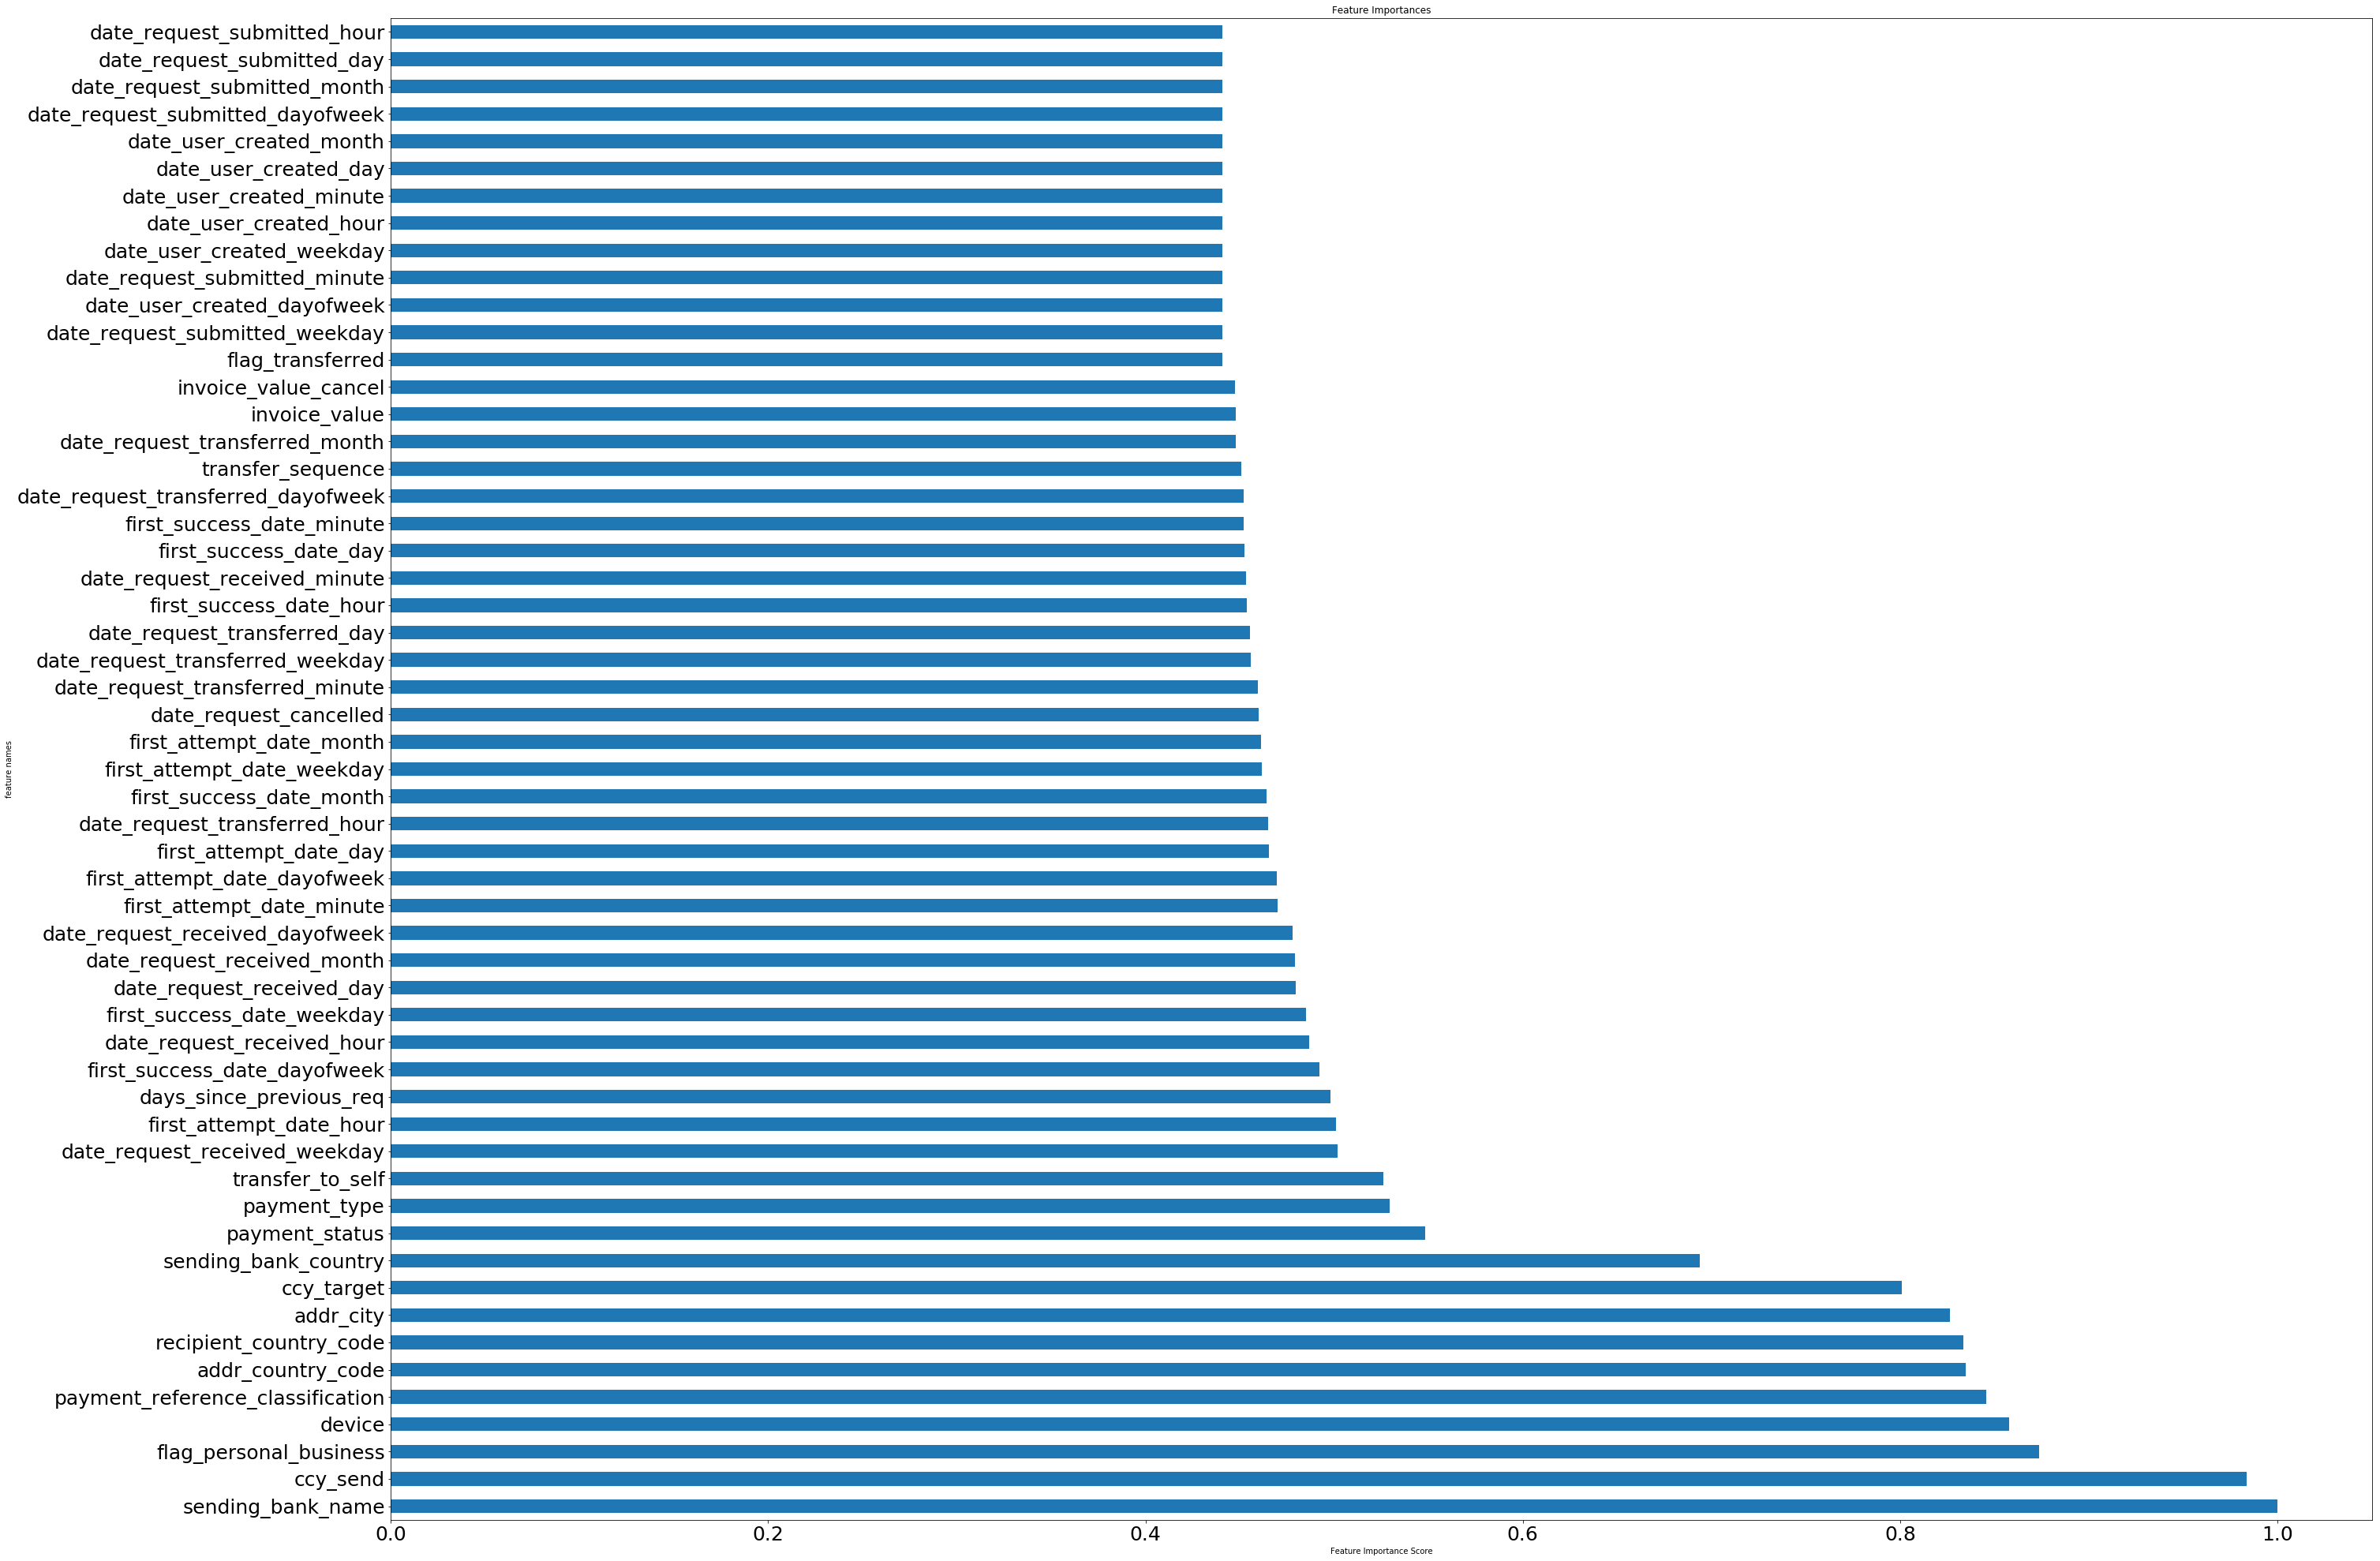

,importance,error
feature names,,
sending_bank_name,1.000000,0.001230
ccy_send,0.983704,0.001210
flag_personal_business,0.873557,0.001075
device,0.857824,0.001055
payment_reference_classification,0.845600,0.001040
addr_country_code,0.834821,0.001027
recipient_country_code,0.833436,0.001025
addr_city,0.826150,0.001016
ccy_target,0.800726,0.000985


In [27]:
perturbation_rank(areg, X.values, y, X.columns.tolist())

In [21]:
y_pred = areg.predict(X_holdout)
error = np.sqrt(metrics.mean_squared_error(y_holdout, y_pred))
print('mse on holdout {}'.format(round(error, 3)))

mse on holdout 0.001


In [28]:
import pickle
filename = "ano_regressor.pkl"
pickle.dump(areg, open(filename, 'wb'))